In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.utils.colab.set_colab_file_id('1Hdo5q151tezwAwmnUELvc3dx5zFrp8Z6')

In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian




[jovian] Detected Colab notebook...


[jovian] Error: Please provide the project argument e.g. jovian.commit(project='my-project')


# Insurance cost prediction using linear regression

Make a submisson here: https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans/assignment/assignment-2-train-your-first-model

In this assignment we're going to use information like a person's age, sex, BMI, no. of children and smoking habit to predict the price of yearly medical bills. This kind of model is useful for insurance companies to determine the yearly insurance premium for a person. The dataset for this problem is taken from [Kaggle](https://www.kaggle.com/mirichoi0218/insurance).


We will create a model with the following steps:
1. Download and explore the dataset
2. Prepare the dataset for training
3. Create a linear regression model
4. Train the model to fit the data
5. Make predictions using the trained model


This assignment builds upon the concepts from the first 2 lessons. It will help to review these Jupyter notebooks:
- PyTorch basics: https://jovian.ai/aakashns/01-pytorch-basics
- Linear Regression: https://jovian.ai/aakashns/02-linear-regression
- Logistic Regression: https://jovian.ai/aakashns/03-logistic-regression
- Linear regression (minimal): https://jovian.ai/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ai/aakashns/mnist-logistic-minimal

As you go through this notebook, you will find a **???** in certain places. Your job is to replace the **???** with appropriate code or values, to ensure that the notebook runs properly end-to-end . In some cases, you'll be required to choose some hyperparameters (learning rate, batch size etc.). Try to experiment with the hypeparameters to get the lowest loss.


In [ ]:
# Uncomment and run the appropriate command for your operating system, if required

# Linux / Binder
# !pip install numpy matplotlib pandas torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# Windows
# !pip install numpy matplotlib pandas torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# MacOS
# !pip install numpy matplotlib pandas torch torchvision torchaudio

In [ ]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [ ]:
project_name='02-insurance-prediction' # will be used by jovian.commit

## Step 1: Download and explore the data

Let us begin by downloading the data. We'll use the `download_url` function from PyTorch to get the data as a CSV (comma-separated values) file. 

In [ ]:
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

To load the dataset into memory, we'll use the `read_csv` function from the `pandas` library. The data will be loaded as a Pandas dataframe. See this short tutorial to learn more: https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/

In [ ]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We're going to do a slight customization of the data, so that you every participant receives a slightly different version of the dataset. Fill in your name below as a string (enter at least 5 characters)

In [ ]:
your_name = 'pySunny' # at least 5 characters

The `customize_dataset` function will customize the dataset slightly using your name as a source of random numbers.

In [ ]:
def customize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [ ]:
dataframe = customize_dataset(dataframe_raw, your_name)
dataframe.head()

,age,sex,bmi,children,smoker,charges
13,56,female,48.18220,0,no,9205.295774
367,42,female,30.23185,2,no,6654.160754
623,18,male,40.57735,0,yes,28732.807740
1281,47,female,33.45045,2,yes,20364.629797
966,51,male,30.00195,2,yes,19892.927932


Let us answer some basic questions about the dataset. 


**Q: How many rows does the dataset have?**

In [ ]:
num_rows = len(dataframe.index)
print(num_rows)
#we use dataframe.index instead of .count or .shape as it is less time consuming

1271


**Q: How many columns doe the dataset have**

In [ ]:
num_cols = len(dataframe.columns)
print(num_cols)

6


**Q: What are the column titles of the input variables?**

In [ ]:
input_cols = dataframe.columns[:5]
input_cols=input_cols.tolist()
print(input_cols)

['age', 'sex', 'bmi', 'children', 'smoker']


**Q: Which of the input columns are non-numeric or categorial variables ?**

Hint: `sex` is one of them. List the columns that are not numbers.

In [ ]:

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

nonNumeric = dataframe.select_dtypes(exclude=numerics)
print(nonNumeric)
categorical_cols=nonNumeric.columns.to_list()
print(categorical_cols)

         sex smoker
13    female     no
367   female     no
623     male    yes
1281  female    yes
966     male    yes
...      ...    ...
1148    male     no
628     male     no
546     male     no
971   female     no
932     male     no

[1271 rows x 2 columns]
['sex', 'smoker']


**Q: What are the column titles of output/target variable(s)?**

In [ ]:
output_cols = dataframe.columns[5:].tolist()

print(output_cols)

['charges']


**Q: (Optional) What is the minimum, maximum and average value of the `charges` column? Can you show the distribution of values in a graph?**
Use this data visualization cheatsheet for referece: https://jovian.ml/aakashns/dataviz-cheatsheet

931.155337
52929.45524830001
11059.752160598404


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


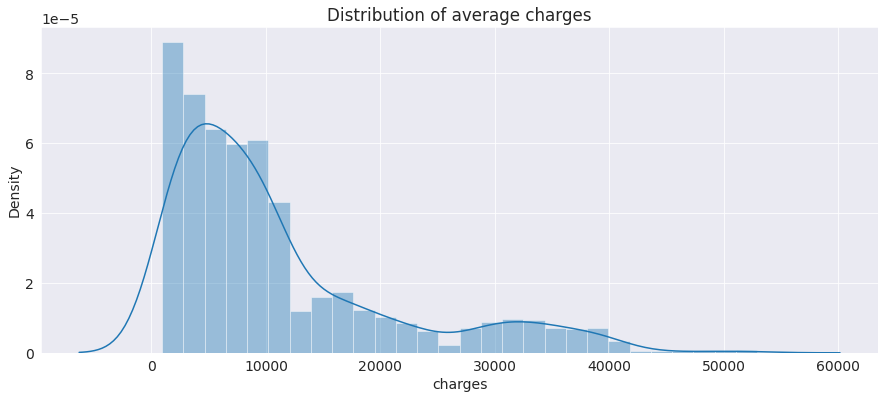

In [ ]:
# Write your answer here
minCharge=dataframe['charges'].min()
print(minCharge)
maxCharge=dataframe['charges'].max()
print(maxCharge)
meanCharge=dataframe['charges'].mean()
print(meanCharge)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (15, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'


plt.title("Distribution of average charges")
sns.distplot(dataframe['charges'])

Remember to commit your notebook to Jovian after every step, so that you don't lose your work.

In [ ]:
!pip install jovian --upgrade -q

In [ ]:
import jovian

In [ ]:
jovian.commit(project='2-insurance-prediction')

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...


ApiError: ignored

## Step 2: Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. If you've filled out `input_cols`, `categorial_cols` and `output_cols` correctly, this following function will perform the conversion to numpy arrays.

In [ ]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

Read through the [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) to understand how we're converting categorical variables into numbers.

In [ ]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[56.     ,  0.     , 48.1822 ,  0.     ,  0.     ],
        [42.     ,  0.     , 30.23185,  2.     ,  0.     ],
        [18.     ,  1.     , 40.57735,  0.     ,  1.     ],
        ...,
        [28.     ,  1.     , 42.87635,  0.     ,  0.     ],
        [34.     ,  0.     , 28.5076 ,  0.     ,  0.     ],
        [46.     ,  1.     , 31.218  ,  5.     ,  0.     ]]),
 array([[ 9205.295774 ],
        [ 6654.1607545],
        [28732.8077395],
        ...,
        [ 2713.1427195],
        [ 4143.672412 ],
        [ 8380.4851   ]]))

**Q: Convert the numpy arrays `inputs_array` and `targets_array` into PyTorch tensors. Make sure that the data type is `torch.float32`.**

In [ ]:
inputs = torch.from_numpy(np.float32(inputs_array))
targets = torch.from_numpy(np.float32(targets_array))

In [ ]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [ ]:
dataset = TensorDataset(inputs, targets)
len(dataset)

1271

**Q: Pick a number between `0.1` and `0.2` to determine the fraction of data that will be used for creating the validation set. Then use `random_split` to create training & validation datasets.**

In [ ]:
val_percent = 0.17 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size

from torch.utils.data import random_split
train_ds, val_ds = random_split(dataset,[train_size,val_size]) # Use the random_split function to split dataset into 2 parts of the desired length

Finally, we can create data loaders for training & validation.

**Q: Pick a batch size for the data loader.**

In [ ]:
batch_size = 20

In [ ]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

Let's look at a batch of data to verify everything is working fine so far.

In [ ]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[48.0000,  0.0000, 32.9907,  1.0000,  0.0000],
        [36.0000,  1.0000, 34.5999,  3.0000,  0.0000],
        [48.0000,  0.0000, 27.5880,  0.0000,  0.0000],
        [57.0000,  1.0000, 28.6770,  0.0000,  0.0000],
        [19.0000,  0.0000, 26.2570,  0.0000,  1.0000],
        [51.0000,  1.0000, 33.5654,  1.0000,  0.0000],
        [31.0000,  1.0000, 43.9230,  2.0000,  1.0000],
        [18.0000,  1.0000, 34.2551,  1.0000,  0.0000],
        [18.0000,  0.0000, 48.1822,  0.0000,  0.0000],
        [52.0000,  0.0000, 22.1854,  0.0000,  0.0000],
        [47.0000,  0.0000, 44.3223,  1.0000,  1.0000],
        [21.0000,  1.0000, 44.6006,  0.0000,  0.0000],
        [30.0000,  0.0000, 34.3398,  1.0000,  1.0000],
        [25.0000,  0.0000, 29.4030,  3.0000,  0.0000],
        [22.0000,  1.0000, 32.4764,  0.0000,  0.0000],
        [24.0000,  1.0000, 43.3906,  0.0000,  0.0000],
        [43.0000,  0.0000, 36.1790,  1.0000,  0.0000],
        [59.0000,  0.0000, 42.1080,  2.0000,  0.0000],
  

Let's save our work by committing to Jovian.

In [ ]:
jovian.commit(project=project_name, environment=None)

## Step 3: Create a Linear Regression Model

Our model itself is a fairly straightforward linear regression (we'll build more complex models in the next assignment). 


In [ ]:
input_size = len(input_cols)
output_size = len(output_cols)

**Q: Complete the class definition below by filling out the constructor (`__init__`), `forward`, `training_step` and `validation_step` methods.**

Hint: Think carefully about picking a good loss fuction (it's not cross entropy). Maybe try 2-3 of them and see which one works best. See https://pytorch.org/docs/stable/nn.functional.html#loss-functions

In [ ]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size,output_size)                  # fill this (hint: use input_size & output_size defined above)
        
    def forward(self, xb):
        out = self.linear(xb)                          # fill this
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.l1_loss(out, targets)                          # fill this
        # l1_loss: Function that takes the mean element-wise absolute value difference.
        # smooth_l1_loss: 
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(out, targets)                           # fill this
        return {'val_loss': loss.detach()}     
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Let us create a model using the `InsuranceModel` class. You may need to come back later and re-run the next cell to reinitialize the model, in case the loss becomes `nan` or `infinity`.

In [ ]:
model = InsuranceModel()

Let's check out the weights and biases of the model using `model.parameters`.

In [ ]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.0354, -0.1816, -0.3237, -0.3231, -0.2354]], requires_grad=True),
 Parameter containing:
 tensor([-0.2124], requires_grad=True)]

One final commit before we train the model.

In [ ]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...


ApiError: ignored

## Step 4: Train the model to fit the data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

**Q: Use the `evaluate` function to calculate the loss on the validation set before training.**

In [ ]:
result = evaluate(model,val_loader) # Use the the evaluate function
print(result)

{'val_loss': 10456.8427734375}



We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or `nan`), you may have to re-initialize the model by running the cell `model = InsuranceModel()`. Experiment with this for a while, and try to get to as low a loss as possible.

**Q: Train the model 4-5 times with different learning rates & for different number of epochs.**

Hint: Vary learning rates by orders of 10 (e.g. `1e-2`, `1e-3`, `1e-4`, `1e-5`, `1e-6`) to figure out what works.

In [ ]:
epochs = 500
lr = 1e-2
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 5668.4614
Epoch [40], val_loss: 5492.3931
Epoch [60], val_loss: 5348.3262
Epoch [80], val_loss: 5252.9814
Epoch [100], val_loss: 5216.2378
Epoch [120], val_loss: 5203.1909
Epoch [140], val_loss: 5198.6714
Epoch [160], val_loss: 5196.3389
Epoch [180], val_loss: 5194.7725
Epoch [200], val_loss: 5193.5962
Epoch [220], val_loss: 5192.0396
Epoch [240], val_loss: 5190.9165
Epoch [260], val_loss: 5190.3770
Epoch [280], val_loss: 5188.7964
Epoch [300], val_loss: 5188.0146
Epoch [320], val_loss: 5186.8081
Epoch [340], val_loss: 5185.3003
Epoch [360], val_loss: 5184.3989
Epoch [380], val_loss: 5183.5132
Epoch [400], val_loss: 5182.7646
Epoch [420], val_loss: 5181.5137
Epoch [440], val_loss: 5180.8022
Epoch [460], val_loss: 5179.7261
Epoch [480], val_loss: 5178.2373
Epoch [500], val_loss: 5177.3267


In [ ]:
epochs = 500
lr = 1e-3
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 5177.3804
Epoch [40], val_loss: 5177.2993
Epoch [60], val_loss: 5177.2051
Epoch [80], val_loss: 5177.1157
Epoch [100], val_loss: 5177.0073
Epoch [120], val_loss: 5176.9238
Epoch [140], val_loss: 5176.8076
Epoch [160], val_loss: 5176.6987
Epoch [180], val_loss: 5176.6074
Epoch [200], val_loss: 5176.5073
Epoch [220], val_loss: 5176.4175
Epoch [240], val_loss: 5176.3105
Epoch [260], val_loss: 5176.2466
Epoch [280], val_loss: 5176.1479
Epoch [300], val_loss: 5176.0347
Epoch [320], val_loss: 5175.9312
Epoch [340], val_loss: 5175.8574
Epoch [360], val_loss: 5175.7397
Epoch [380], val_loss: 5175.6538
Epoch [400], val_loss: 5175.5469
Epoch [420], val_loss: 5175.4526
Epoch [440], val_loss: 5175.3682
Epoch [460], val_loss: 5175.2349
Epoch [480], val_loss: 5175.1567
Epoch [500], val_loss: 5175.0459


In [ ]:
epochs = 800
lr = 1e-5
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 5175.0459
Epoch [40], val_loss: 5175.0454
Epoch [60], val_loss: 5175.0449
Epoch [80], val_loss: 5175.0449
Epoch [100], val_loss: 5175.0449
Epoch [120], val_loss: 5175.0439
Epoch [140], val_loss: 5175.0444
Epoch [160], val_loss: 5175.0444
Epoch [180], val_loss: 5175.0435
Epoch [200], val_loss: 5175.0425
Epoch [220], val_loss: 5175.0410
Epoch [240], val_loss: 5175.0405
Epoch [260], val_loss: 5175.0396
Epoch [280], val_loss: 5175.0391
Epoch [300], val_loss: 5175.0376
Epoch [320], val_loss: 5175.0361
Epoch [340], val_loss: 5175.0352
Epoch [360], val_loss: 5175.0337
Epoch [380], val_loss: 5175.0327
Epoch [400], val_loss: 5175.0312
Epoch [420], val_loss: 5175.0303
Epoch [440], val_loss: 5175.0298
Epoch [460], val_loss: 5175.0283
Epoch [480], val_loss: 5175.0278
Epoch [500], val_loss: 5175.0264
Epoch [520], val_loss: 5175.0249
Epoch [540], val_loss: 5175.0234
Epoch [560], val_loss: 5175.0229
Epoch [580], val_loss: 5175.0215
Epoch [600], val_loss: 5175.0215
Epoch [620], v

In [ ]:
epochs = 900
lr = 1e-2
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 5173.6958
Epoch [40], val_loss: 5173.1909
Epoch [60], val_loss: 5172.0146
Epoch [80], val_loss: 5170.8354
Epoch [100], val_loss: 5170.4678
Epoch [120], val_loss: 5169.0474
Epoch [140], val_loss: 5168.1201
Epoch [160], val_loss: 5167.3101
Epoch [180], val_loss: 5166.5161
Epoch [200], val_loss: 5165.5342
Epoch [220], val_loss: 5164.6479
Epoch [240], val_loss: 5163.4712
Epoch [260], val_loss: 5162.6543
Epoch [280], val_loss: 5161.7075
Epoch [300], val_loss: 5160.8066
Epoch [320], val_loss: 5160.0190
Epoch [340], val_loss: 5159.2310
Epoch [360], val_loss: 5158.4443
Epoch [380], val_loss: 5157.8545
Epoch [400], val_loss: 5156.7036
Epoch [420], val_loss: 5156.0723
Epoch [440], val_loss: 5155.1562
Epoch [460], val_loss: 5154.6030
Epoch [480], val_loss: 5154.2319
Epoch [500], val_loss: 5152.8081
Epoch [520], val_loss: 5152.1802
Epoch [540], val_loss: 5151.2910
Epoch [560], val_loss: 5150.6226
Epoch [580], val_loss: 5149.8057
Epoch [600], val_loss: 5149.4292
Epoch [620], v

In [ ]:
epochs = 1000
lr = 1e-4
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 5138.4531
Epoch [40], val_loss: 5138.4458
Epoch [60], val_loss: 5138.4380
Epoch [80], val_loss: 5138.4316
Epoch [100], val_loss: 5138.4253
Epoch [120], val_loss: 5138.4204
Epoch [140], val_loss: 5138.4150
Epoch [160], val_loss: 5138.4141
Epoch [180], val_loss: 5138.4146
Epoch [200], val_loss: 5138.4155
Epoch [220], val_loss: 5138.4185
Epoch [240], val_loss: 5138.4170
Epoch [260], val_loss: 5138.4185
Epoch [280], val_loss: 5138.4204
Epoch [300], val_loss: 5138.4204
Epoch [320], val_loss: 5138.4146
Epoch [340], val_loss: 5138.4058
Epoch [360], val_loss: 5138.4014
Epoch [380], val_loss: 5138.3984
Epoch [400], val_loss: 5138.3926
Epoch [420], val_loss: 5138.3857
Epoch [440], val_loss: 5138.3784
Epoch [460], val_loss: 5138.3730
Epoch [480], val_loss: 5138.3657
Epoch [500], val_loss: 5138.3599
Epoch [520], val_loss: 5138.3535
Epoch [540], val_loss: 5138.3481
Epoch [560], val_loss: 5138.3418
Epoch [580], val_loss: 5138.3345
Epoch [600], val_loss: 5138.3301
Epoch [620], v

**Q: What is the final validation loss of your model?**

In [ ]:
val_loss = 5138.2090

Let's log the final validation loss to Jovian and commit the notebook

In [ ]:
jovian.log_metrics(val_loss=val_loss)

In [ ]:
jovian.commit(project=project_name, environment=None)

Now scroll back up, re-initialize the model, and try different set of values for batch size, number of epochs, learning rate etc. Commit each experiment and use the "Compare" and "View Diff" options on Jovian to compare the different results.

## Step 5: Make predictions using the trained model

**Q: Complete the following function definition to make predictions on a single input**

In [ ]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)               # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [ ]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([58.0000,  0.0000, 38.5083,  2.0000,  0.0000])
Target: tensor([11294.1162])
Prediction: tensor([10264.1055])


In [ ]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([48.0000,  1.0000, 37.2438,  3.0000,  0.0000])
Target: tensor([8417.1426])
Prediction: tensor([8338.3525])


In [ ]:
input, target = val_ds[23]
predict_single(input, target, model)

Input: tensor([34.0000,  1.0000, 30.5767,  1.0000,  0.0000])
Target: tensor([4062.6453])
Prediction: tensor([5465.9399])


Are you happy with your model's predictions? Try to improve them further.

## (Optional) Step 6: Try another dataset & blog about it

While this last step is optional for the submission of your assignment, we highly recommend that you do it. Try to replicate this notebook for a different linear regression or logistic regression problem. This will help solidify your understanding, and give you a chance to differentiate the generic patterns in machine learning from problem-specific details.You can use one of these starer notebooks (just change the dataset):

- Linear regression (minimal): https://jovian.ai/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ai/aakashns/mnist-logistic-minimal

Here are some sources to find good datasets:

- https://lionbridge.ai/datasets/10-open-datasets-for-linear-regression/
- https://www.kaggle.com/rtatman/datasets-for-regression-analysis
- https://archive.ics.uci.edu/ml/datasets.php?format=&task=reg&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table
- https://people.sc.fsu.edu/~jburkardt/datasets/regression/regression.html
- https://archive.ics.uci.edu/ml/datasets/wine+quality
- https://pytorch.org/docs/stable/torchvision/datasets.html

We also recommend that you write a blog about your approach to the problem. Here is a suggested structure for your post (feel free to experiment with it):

- Interesting title & subtitle
- Overview of what the blog covers (which dataset, linear regression or logistic regression, intro to PyTorch)
- Downloading & exploring the data
- Preparing the data for training
- Creating a model using PyTorch
- Training the model to fit the data
- Your thoughts on how to experiment with different hyperparmeters to reduce loss
- Making predictions using the model

As with the previous assignment, you can [embed Juptyer notebook cells & outputs from Jovian](https://medium.com/jovianml/share-and-embed-jupyter-notebooks-online-with-jovian-ml-df709a03064e) into your blog. 

Don't forget to share your work on the forum: https://jovian.ai/forum/t/linear-regression-and-logistic-regression-notebooks-and-blog-posts/14039

In [ ]:

jovian.commit() # try again, kaggle fails sometimes

[jovian] Detected Colab notebook...


[jovian] Error: Please provide the project argument e.g. jovian.commit(project='my-project')
